# **Using convolutional neural network for sports activity detection from videos**
### Student project for CS-EJ3311 - Deep Learning with Python, 09.09.2020-18.12.2020
 
Sami Mönkölä
sami.monkola@aalto.fi

---



# 1. Introduction

This deep learning application is figuring out from a video what sports activities, if any, are happening in a video. The application produces a copy of the video with a caption indicating detected sports activity for a certain part of the video, meaning the input video can have a compilation of multiple different sport activities.

After the brief introduction what kind of a problem this deep learning application is solving, this report provides more techinal formulation of the problem, methods and walkthrough of solving the problem, results of the problem solving process, and finally analyzes of the results and summary of the findings during the application development. At the end we will use the application to process an example video file to see the practical results.  


In [ ]:
# import Python packages and libraries

# provides functionality to train neural network
import tensorflow as tf

# functionality for real-time image data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# provides functionality for cross validation
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

# provides functionality to binarize labels in a one-vs-all fashion
from sklearn.preprocessing import LabelBinarizer

# provides metrics to evaluate models
from sklearn.metrics import confusion_matrix, classification_report

# provides mathematical functions to operate on arrays and matrices
import numpy as np

# data analysis library
import pandas as pd

# library to interact with operating system
import os

# plotting libraries for graphs and images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# statistical data visualization library
import seaborn as sns

# library for pretty-printing tabular data
from tabulate import tabulate

# high level file copying
import shutil

# library for creating temporary directories and files
import tempfile

# provides mathematical functions
import math

# provides timing functions
import time


In [ ]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# define the project source dir
source_dir = '/content/drive/My Drive/dlpython/source/student_project'

# set the path 
os.sys.path.append(source_dir)


Mounted at /content/drive


In [ ]:
# provides method for plotting model's training result graphs. 
# the file is a direct copy from the course material.
from plot_history import plot_history

# 2. Problem formulation

Data points are images stored in the "sports_small" directory. One particular image corresponds to one particular data point. Each of these images belongs to one of six different classes "cliff_jumping", "longboarding", "snowboarding", "sprint_running", "surfing" and "swimming". For each class there is a subdirectory where images belonging to particular class is being stored.

Each image has several features, which are maps from image pixels. 

The problem is a categorical multiclassification problem, because we have six different classes and an image can belong to one class. Categories are defined using [one-hot encoding](https://deepai.org/machine-learning-glossary-and-terms/one-hot-encoding) which means a binary label vector $y$ is assigned to each image. For example, if an image would belong to class "swimming", the binary label vector would be $y$ = $[0, 0, 0, 0, 0, 1]$.

The chosen quality metric is categorical accuracy score. 

It is important to note here that using only accuracy as a quality metric is not necessarily a good choice, especially when using an imbalanced data set. Imbalanced data set means that the sample sizes differs a lot between different classes. The reason and examples are explained in [Why accuracy alone is a bad measure for classification tasks, and what we can do about it](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/) (Descoins, Alan, 25 Mar 2013).


# 3. Methods

In this chapter we're going through how the dataset was formed, what data preprocessing methods was used, architecure of the convolutiona neural network model, hyperparameters, how cross-validation was applied and how the final model was being trained.

## 3.1 Forming the dataset

Dataset source was [the Google image search](https://images.google.com/). After downloading the images, I checked and removed duplicate images and made sure every image had a valid filename extension (jpg, jpeg, or png) for an [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to recognize those as valid files.

Then I split the dataset to training and testing images by using 80/20 split meaning 80 % of the dataset is used for training and 20 % of the dataset is used for testing. [Splitting into train, dev and test sets](http://cs230.stanford.edu/blog/split/) (blog of the Stanford University class CS230 - Deep Learning) instructs it being a good practice to split the data 80/10/10 when using an image dataset, so 80 % for training, 10 % for validation and 10 % for testing. Here I have quite a small dataset so I chose to use only training and testing splits and use a cross-validation instead of splitting the dataset into three parts.  

The training part of the dataset is under directory "train" and the testing part under directory "test" and both of those contains individual subdirectories for each of the classes. I have different sample size in different classes so I made an 80-20 split respective to an individual class sample size. I chose randomly which images to use as a training dataset and which ones to use as testing dataset.

The project's data directory structure is displayed below the next code block.

In [ ]:
# walk through the root dir and print subdirectories in a tree-like view
# parameters:
#     root: root directory go start tarversing directories recursively from
#     sub_level: the subdirectory level in a tree hierarchy
def walk_dir(root, sub_level=1):
  prepend = sub_level * '---'
  for lists in os.listdir(root):
    path = os.path.join(root, lists)
    path_len = len(root.split('/'))
    if os.path.isdir(path):
      name = path.split('/')[-1]
      print('|', prepend, name)
      # recursive call, increase the sub level by one
      walk_dir(path, sub_level=sub_level+1)

# define the project base dir and call walk_dir to print the directory structure 
base_dir = '/content/drive/My Drive/dlpython/data/sports_small'
print("Project's data directory structure\n")
print(base_dir)
walk_dir(base_dir)


Project's data directory structure

/content/drive/My Drive/dlpython/data/sports_small
| --- test
| ------ snowboarding
| ------ sprint_running
| ------ cliff_jumping
| ------ longboarding
| ------ surfing
| ------ swimming
| --- video
| --- train
| ------ longboarding
| ------ cliff_jumping
| ------ surfing
| ------ sprint_running
| ------ snowboarding
| ------ swimming


Next we compute used dataset sizes, how many images belongs to each class, separated to training and testing splits, inlucindg total training and testing image count. 


In [ ]:
# The base directory to the dataset
base_dir = '/content/drive/My Drive/dlpython/data/sports_small'

# Directories for training and test splits
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Directories with training sports pictures
train_surfing_dir         = os.path.join(train_dir, 'surfing')
train_snowboarding_dir    = os.path.join(train_dir, 'snowboarding')
train_sprint_running_dir  = os.path.join(train_dir, 'sprint_running')
train_longboarding_dir    = os.path.join(train_dir, 'longboarding')
train_cliff_jumping_dir   = os.path.join(train_dir, 'cliff_jumping')
train_swimming_dir        = os.path.join(train_dir, 'swimming')

# Directories with test sports pictures
test_surfing_dir          = os.path.join(test_dir, 'surfing')
test_snowboarding_dir     = os.path.join(test_dir, 'snowboarding')
test_sprint_running_dir   = os.path.join(test_dir, 'sprint_running')
test_longboarding_dir     = os.path.join(test_dir, 'longboarding')
test_cliff_jumping_dir    = os.path.join(test_dir, 'cliff_jumping')
test_swimming_dir         = os.path.join(test_dir, 'swimming')

total_train_files = 0   # counter for training pictures
total_test_files = 0    # counter for test pictures

# list the directories in training_dirs and testing_dirs in alphabetical order
# because we're using these later assuming they are so
training_dirs = [train_cliff_jumping_dir, train_longboarding_dir, train_snowboarding_dir,
                 train_sprint_running_dir, train_surfing_dir, train_swimming_dir]

testing_dirs = [test_cliff_jumping_dir, test_longboarding_dir, test_snowboarding_dir,
                test_sprint_running_dir, test_surfing_dir, test_swimming_dir]

for dir in training_dirs:
  total_train_files += len(os.listdir(dir))

for dir in testing_dirs:
  total_test_files += len(os.listdir(dir))

# Create tabular data how many images we have for each label, training and testing separated
image_counts = []
image_counts.append(['surfing', len(os.listdir(train_surfing_dir)), len(os.listdir(test_surfing_dir))])
image_counts.append(['snowboarding', len(os.listdir(train_snowboarding_dir)), len(os.listdir(test_snowboarding_dir))])
image_counts.append(['sprint running', len(os.listdir(train_sprint_running_dir)), len(os.listdir(test_sprint_running_dir))])
image_counts.append(['longboarding', len(os.listdir(train_longboarding_dir)), len(os.listdir(test_longboarding_dir))])
image_counts.append(['cliff jumping', len(os.listdir(train_cliff_jumping_dir)), len(os.listdir(test_cliff_jumping_dir))])
image_counts.append(['swimming', len(os.listdir(train_swimming_dir)), len(os.listdir(test_swimming_dir))])
image_counts.append(['----------------', '--------', '--------'])
image_counts.append(['Total count', total_train_files, total_test_files])

print(tabulate(image_counts, headers=["Sport", "Training images", "Testing images"]))


Sport             Training images    Testing images
----------------  -----------------  ----------------
surfing           118                29
snowboarding      85                 21
sprint running    437                109
longboarding      155                38
cliff jumping     145                36
swimming          363                90
----------------  --------           --------
Total count       1303               323


As it can be seen, the dataset sample sizes varies quite a lot between different classes. For example for snowboarding there are only 85 images for training and 21 for testing when on the other hand sprint running has 437 images for training and 109 images for testing.

Let's create an ImageDataGenerator object to display sample images from the training dataset.



Found 1303 images belonging to 6 classes.


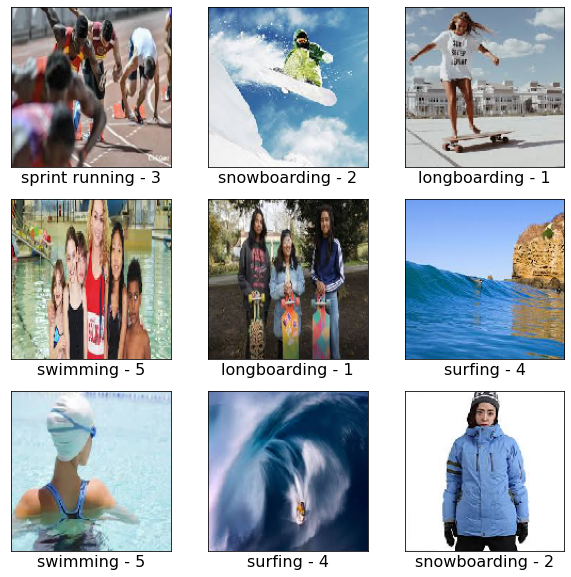

In [ ]:
# ImageDataGenerator object and generator function is created here only to be
# able to display images with their labels effortlessly.
# Those will be created again when we get to model development and training the model.

# create ImageDataGenerator object for training data
train_datagen = ImageDataGenerator(rescale = 1./255)

# create generator function for training dataset
train_generator = train_datagen.flow_from_directory(batch_size=32,
                                                    directory=train_dir,
                                                    target_size=(150, 150),
                                                    class_mode='categorical')

# retrieve first values
image_batch1, label_batch1 = next(train_generator)

# create figure object
fig = plt.figure(1,figsize=(10,10))

# list containing x axis labels
class_name = ['cliff jumping', 'longboarding', 'snowboarding', 'sprint running', 'surfing', 'swimming']

# plot first 9 images from the training dataset
for i in range(9):
    # create an empty subplot
    plt.subplot(3,3,i+1)
    # read the image file 
    image = plt.imshow(image_batch1[i])
    
    # format axes 
    plt.xticks([])  # remove x axis ticks        
    plt.yticks([])  # remove y axis ticks
    
    # set the image x axis label
    label_index = np.where(label_batch1[i] == 1)[0][0]
    label = class_name[label_index]
    plt.xlabel(label+" - "+str(label_index), fontsize = 16)
    
plt.show()

## 3.2 Data preprocessing

Here three methods are introduced which are used for preprocessing the data.

**copy_files_to_dir** is used when we get to the cross-validation part. There training dataset is splitted to training and validation parts in each cross-validation fold and the image files used in a fold are being copied under individual temporary directory, keeping separate subdirectories for each class.

**augment_images** is used to create ImageDataGenerator object and generator function for training data. Because my dataset is small in size, I'm using data augmentation when creating ImageDataGenerator object inside the method. The purpose to use data augmentation is to reduce overfitting. 

**collect_filenames_and_classes** is used to collect all training set files with respective labels from training directories into a lists for cross- validator to make fold splits for the training data.


In [ ]:
# copies files in subdirectories respective to their classes under main directory
# parameters:
#    filenames: array of absolute filenames to be copied
#    classes: array of file labels, respectively to filenames array
#    label_binarizer: binarized labels
#    main_dir: base directory where to copy the files

def copy_files_to_dir(filenames, classes, label_binarizer, main_dir):
  # create subdirectories for each class
  for class_name in label_binarizer.classes_:
    os.mkdir(os.path.join(main_dir, class_name))
  
  for i in range(filenames.size):
    file = filenames[i]
    ext = os.path.splitext(file)[1]
    if ext == '':
      ext = '.jpg' # make sure the file has a valid extension
    # create new individual destination filename to prevent shutil
    # from overwriting existing files with identical names
    new_filename = str(i+1) + ext
    new_file = os.path.join(main_dir, classes[i], new_filename)
    shutil.copy(file, new_file)

  # Notice it somehow if there was a failure copying needed files,
  # because that would make the model's score results useless.
  # Checks only that the number of copied files matches to the number
  # of files needed to be copied.
  copied_files_count = 0
  for class_name in label_binarizer.classes_:
    copied_files_count += len(os.listdir(os.path.join(main_dir, class_name)))

  if copied_files_count != filenames.size:
    print("WARNING: Not all files were copied!")


# creates generator function with image augmentation for training purposes
# parameters:
#    train_dir: base directory for training dataset
#    label_binarizer: binarized labels
#    img_target_size: tuple of pixels for resizing images to a fixed size
# returns:
#    generator function for training dataset 

def augment_images(train_dir, label_binarizer, batch_size=32, img_target_size=(180, 180)):
  # create ImageDataGenerator object for training data with augmentation
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=50,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

  # create generator function for training dataset
  train_generator = train_datagen.flow_from_directory(batch_size=batch_size,
                                                      directory=train_dir,
                                                      target_size=img_target_size,
                                                      color_mode='rgb',
                                                      class_mode='categorical',
                                                      shuffle=True)
  

  return train_generator

# collect files with absolute pathnames and respective labels from given directories
# parameters:
#    class_array: array of class names
#    dir_array: array of directories to collect filenames
# returns:
#    tuple of arrays for absolute filenames and respective labels for the files  

def collect_filenames_and_classes(class_array, dir_array):
  filenames = []
  file_classes = []

  i = 0 # keep index of the class
  for dir in dir_array:
    for filename in os.listdir(dir):
      path = os.path.abspath(dir)
      filenames.append(os.path.join(path, filename))
      file_classes.append(class_name[i])
    i += 1

  return (filenames, file_classes)


Since we previously displyed sample images of the training dataset, let's now in comparison display sample training images with data augmentation by using previously defined *augment_images* method.

Found 1303 images belonging to 6 classes.


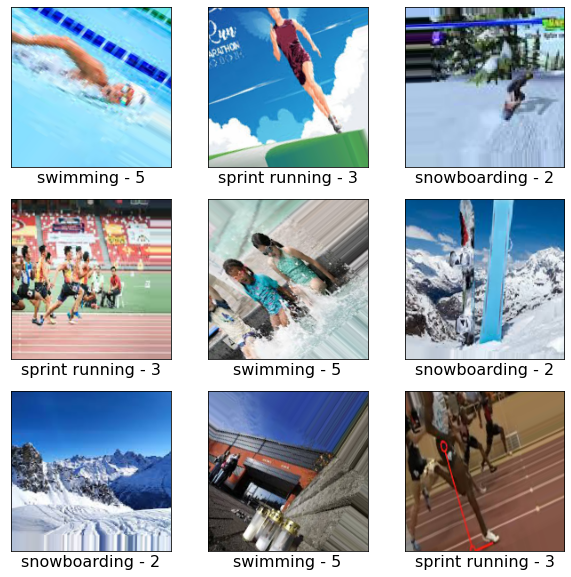

In [ ]:
# binarize labels
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(np.array(class_name))

# create generator function with augmented images to display some of them
train_generator = augment_images(train_dir, label_binarizer)

# retrieve first values
image_batch1, label_batch1 = next(train_generator)

# create figure object
fig = plt.figure(1,figsize=(10,10))

# plot first 9 images from the training dataset
for i in range(9):
    # create an empty subplot
    plt.subplot(3,3,i+1)
    # read the image file 
    image = plt.imshow(image_batch1[i])
    
    # format axes 
    plt.xticks([])  # remove x axis ticks        
    plt.yticks([])  # remove y axis ticks
    
    # set the image x axis label
    label_index = np.where(label_batch1[i] == 1)[0][0]
    label = class_name[label_index]
    plt.xlabel(label+" - "+str(label_index), fontsize = 16)
    
plt.show()

## 3.3 Model architecture

Now it is time to decide the model architecture for our deep learning application. Being an unexperienced with deep learning models, I followed  [TensorFlow's Image classification tutorial](https://www.tensorflow.org/tutorials/images/classification#dropout) and decided to try the one using a [Dropout layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), which is supposed to reduce overfitting by dropping a specified amount of the output units randomly from the applied layer.

The choice of artificial neural network structure will define the predictor map. The chosen structure contains 10 layers:

Input → 3* (Conv → Pool) → Dropout → Flatten → Dense → Dense

In convolutional layers padding will be used and the activation function is going to be rectified linear units (ReLu) function and in the output layer the activation function is going to be softmax function. This has been chosen since that is how it is been conventionally done in classification problems, like said in [Deep Learning using Rectified Linear Units (ReLU)](https://www.researchgate.net/publication/323956667_Deep_Learning_using_Rectified_Linear_Units_ReLU) (Abien Fred Agarap, Mar 2018).  

The loss function will be categorical cross-entropy function, which is typically used together with softmax activation function for multi-class classification problems.

For optimizer I researched [available optimizers](https://keras.io/api/optimizers/#available-optimizers) from Keras API reference and decided to use [Adam](https://keras.io/api/optimizers/#available-optimizers) after reading it is being an efficient optimizer needing relatively little memory [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) (Kingma, D.P. and Lei Ba, J., 2017) It is also said in the paper that good default learning rate and epsilon values for tested machine learning problems are $learning\_rate = 0.001$ and $epsilon = 1e-08$.

Metrics written in the code block below are only accuracy but as I mentioned earlier, in practice it is categorical accuracy. Like it is said in [Keras Metrics: Everything You Need To Know](https://neptune.ai/blog/keras-metrics), the term "accuracy" is an expression and Keras decides which accuracy (binary accuracy, categorical accuracy or sparse categorical accuracy) to use under the hood.

In addition to the accuracy metrics, which gives scores for loss and accuracy, sklearn's [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) are also used to see more detailed and classification specific score reports.




In [ ]:
# define the sequential model architecture 
# parameters:
#     label_binarizer: binarized labels of class names
#     lr: learning rate for optimizer to use
#     epsilon: epsilon value for optimizer to use
#     input_shape: the shape of the starting tensor
#     dropout: dropout value for Dropout layer
# returns:
#    optimized model

def sequential_model_architecture(label_binarizer, lr=0.001, epsilon=1e-08, input_shape=(180, 180, 3), dropout=0.2):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D())
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(len(label_binarizer.classes_), activation='softmax'))

  # compile the model
  opt = tf.keras.optimizers.Adam(learning_rate=lr,
                                 epsilon=epsilon)
  
  model.compile(loss="categorical_crossentropy",
                optimizer=opt,
                metrics=["accuracy"])


  return model


model = sequential_model_architecture(label_binarizer)
model.summary()  # print the model summary


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0

## 3.4 Hyperparameters

Hyperparameters are external to the model and can't be estimated from the data. [Hyperparameter Optimization in Convolutional Neural Network using Genetic Algorithms](https://dx.doi.org/10.14569/IJACSA.2019.0100638) (Nurshazlyn Mohd Aszemi and P.D.D Dominic, 2019) divides hyperparameters into two types which are hyperparameters determining the network structure and hyperparameters determining the network training. Ones affecting the network training are such as learning rate, momentum, epoch count and batch size. Ones affecting the network structure are for example kernel size and type, stride, padding, hidden layer and activation functions.  

In the previous section called *Model architecture* we went through some of the hyperparameters affecting the network structure, like padding, hidden layers and activation functions. In the code block below I have denifed some of the  hyperparameters affecting the network training, like epoch count, batch size, learning rate, epsilon and dropout parameter value. In addition to those there are some widely used variables which are not hyperparameters at all.


In [ ]:
# collect filenames and respective labels for numpy arrays from the training dataset
filenames, file_classes = collect_filenames_and_classes(class_name, training_dirs)
np_filenames = np.array(filenames)
np_classes = np.array(file_classes)

epochs = 100                    # number of epochs
batch_size = 32                 # batch size
learning_rate = 0.0001          # learning rate value for optimizer
epsilon = 1e-08                 # epsilon value for optimizer
dropout = 0.1                   # dropout parameter value for the dropout layer for model architecture
img_target_size = (180, 180)    # fixed size for images to be resized
img_shape = (img_target_size[0], img_target_size[1], 3) # starting tensor shape for model architecture


## 3.5 Cross-validation

Ten fold cross-validation is commonly used which means there are 10 folds in cross-validation process. We're using the same number, 10 folds. Normally in deep learning applications cross-validation is not used since it increases time the application runs because the model is being created and trained again in each cross-validation fold. But on the other hand, usually deep learning applications has large amounts of data points and in those cases it is better to split data into three parts, including validation part. 

Like mentioned before, the data point sizes between each class varies in the dataset. For that reason [K-Fold cross validation ](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) would not be as good option as [Stratified K-Folds cross validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), because the Stratified version returns stratified folds, so that is chosen to be used here.

When using cross-validation, that is the phase where one can see how the model performs tune the hyperparameters until the model performance is satisfactory.

Here two different models are ran side-by-side in cross-validation. The variable names are *mode*l and *comparison_model*.


In [ ]:
# Check the output to see how long it takes to process this code block on Colab GPU
start_time = time.process_time()

k_folds = 10      # number of cross-validation folds
current_fold = 1  # counter to keep track of the current fold number

# arrays to hold model scores from each cross-validation fold
model_test_losses = []
model_test_accuracies = []
model_true_predictions = []
model_reports = []
comparison_model_test_losses = []
comparison_model_test_accuracies = []
comparison_model_true_predictions = []
comparison_model_reports = []

# numpy array holding the sum of every folds's confusion matrices
model_cf_matrices_sum = np.zeros((len(label_binarizer.classes_), len(label_binarizer.classes_)))
comparison_model_cf_matrices_sum = np.zeros((len(label_binarizer.classes_), len(label_binarizer.classes_)))

# initialize the stratified k-fold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=1)

# generate indices to split the data for training and testing set 
for train_index, test_index in skf.split(filenames, file_classes):    
    print("=========== Fold number", current_fold, "===========")

    # create the sequential model
    model = sequential_model_architecture(label_binarizer,
                                          lr=learning_rate,
                                          epsilon=epsilon,
                                          input_shape=img_shape,
                                          dropout=dropout)

    comparison_model = sequential_model_architecture(label_binarizer,
                                                     lr=learning_rate,
                                                     epsilon=epsilon,
                                                     input_shape=img_shape,
                                                     dropout=0.4)

    # split our files in the original training dataset to training and testing parts
    train_files = np_filenames[train_index]
    train_classes = np_classes[train_index]

    test_files = np_filenames[test_index]
    test_classes = np_classes[test_index]

    # create temporary directory and copy the training set used in current CV fold
    # into that directory, using subdirectories for each class 
    tmp_folded_train_dir = tempfile.TemporaryDirectory()
    folded_train_dir = tmp_folded_train_dir.name
    copy_files_to_dir(train_files, train_classes, label_binarizer, folded_train_dir)
    
    # create generator function for the training set used in current CV fold
    train_generator = augment_images(folded_train_dir,
                                     label_binarizer,
                                     batch_size=batch_size,
                                     img_target_size=img_target_size)

    # create temporary directory and copy the testing set used in current CV fold
    # into that directory, using subdirectories for each class 
    tmp_folded_test_dir = tempfile.TemporaryDirectory()
    folded_test_dir = tmp_folded_test_dir.name
    copy_files_to_dir(test_files, test_classes, label_binarizer, folded_test_dir)

    # ImageDataGenerator object and generator function for the testing set used in
    # current CV fold
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_directory(batch_size=batch_size,
                                                      directory=folded_test_dir,
                                                      target_size=img_target_size,
                                                      color_mode='rgb',
                                                      class_mode='categorical',
                                                      shuffle=False)
  
    # fit and evaluate the CNN model
    history = model.fit(train_generator, 
                       epochs=epochs, 
                       validation_data = val_generator)

    test_loss, test_acc = model.evaluate(val_generator)
    model_test_losses.append(test_loss)
    model_test_accuracies.append(test_acc)

    # get the model predictions to generate confusion matrix 
                                                 # 1.0 is to avoid integer division
    generator_steps = math.ceil(val_generator.n / (1.0 * batch_size))
    pred = model.predict(val_generator, steps = generator_steps)

    predicted_class_indices = np.argmax(pred, axis=1)
    cfm = confusion_matrix(val_generator.classes, predicted_class_indices)
    # sum current fold's confusion matrix with the previous folds' confusion matrices
    model_cf_matrices_sum += np.array(cfm)

    # save current fold's classification report for further analysis
    report = classification_report(val_generator.classes, predicted_class_indices, target_names=label_binarizer.classes_, output_dict=True)
    model_reports.append(report)

    true_predictions = np.sum(np.diagonal(cfm))
    model_true_predictions.append(true_predictions)


    # fit and evaluate the other CNN model with slightly different hyperparameter(s)
    train_generator.reset()
    val_generator.reset()

    history = comparison_model.fit(train_generator, 
                                   epochs=epochs, 
                                   validation_data = val_generator)

    comparison_test_loss, comparison_test_acc = comparison_model.evaluate(val_generator)
    comparison_model_test_losses.append(comparison_test_loss)
    comparison_model_test_accuracies.append(comparison_test_acc)

    # get the model predictions to generate confusion matrix 
                                                 # 1.0 is to avoid integer division
    generator_steps = math.ceil(val_generator.n / (1.0 * batch_size))
    pred = comparison_model.predict(val_generator, steps = generator_steps)

    predicted_class_indices = np.argmax(pred, axis=1)
    comparison_cfm = confusion_matrix(val_generator.classes, predicted_class_indices)
    # sum current fold's confusion matrix with the previous folds' confusion matrices
    comparison_model_cf_matrices_sum += np.array(comparison_cfm)

    # save current fold's classification report for further analysis
    report = classification_report(val_generator.classes, predicted_class_indices, target_names=label_binarizer.classes_, output_dict=True)
    comparison_model_reports.append(report)

    comparison_true_predictions = np.sum(np.diagonal(cfm))
    comparison_model_true_predictions.append(comparison_true_predictions)

    # print minimal model scores at the end of each CV fold
    print("\nFold", current_fold, "results")
    fold_results = []
    fold_results.append(['Accuracy', f'{test_acc:.2f}', f'{comparison_test_acc:.2f}'])
    fold_results.append(['Loss', f'{test_loss:.2f}', f'{comparison_test_loss:.2f}'])
    fold_results.append(['True predictions', true_predictions, comparison_true_predictions])
    print(tabulate(fold_results, headers=['','Original model', 'Comparison model']))
    print("Original model's confusion matrix:")
    print(cfm)
    print("Comaprison model's confusion matrix:")
    print(comparison_cfm)
    print("\n\n")

    # tidy up after each CV fold
    tmp_folded_train_dir.cleanup()
    tmp_folded_test_dir.cleanup()
    tf.keras.backend.clear_session()
    current_fold += 1

# compute average accuracy and loss metrics from all CV folds
mean_acc = np.mean(model_test_accuracies)
mean_loss = np.mean(model_test_losses)
comparison_mean_acc = np.mean(comparison_model_test_accuracies)
comparison_mean_loss = np.mean(comparison_model_test_losses)
# sum all models' true predictions
sum_true_preds = np.sum(model_true_predictions)
comparison_sum_true_preds = np.sum(comparison_model_true_predictions)

# compute average classification report metrics from all the CV folds'
# classification report metrics
mean_classification_report = dict()
comparison_mean_classification_report = dict()
metric_keys = ['precision', 'recall', 'f1-score', 'support']
dict_keys = np.concatenate((label_binarizer.classes_, np.array(['macro avg', 'weighted avg'])))

# loop every class and every metric from all the saved CV fold classification reports
# and sum the original model's values to 'metrics' dictionary and comparison model's
# values to 'comparison_metrics' dictionary.
for d_key in dict_keys:
  metrics = dict()
  comparison_metrics = dict()
  for m_key in metric_keys:
    metrics[m_key] = 0
    comparison_metrics[m_key] = 0
  for i in range(k_folds):
    for m_key in metric_keys:
      metrics[m_key] += model_reports[i][d_key][m_key]
      comparison_metrics[m_key] += comparison_model_reports[i][d_key][m_key]

  # compute the average of each metric by dividing the summed values
  # by the fold amount used in the CV and save it in 'mean_metrics'
  # dictionary for the original model and in 'comparison_mean_metrics'
  # dictionary for the comaprison model.
  mean_metrics = dict()
  comparison_mean_metrics = dict()
  for m_key in metric_keys:
    mean_metrics[m_key] = metrics[m_key] * 1.0 / k_folds
    comparison_mean_metrics[m_key] = comparison_metrics[m_key] * 1.0 / k_folds

  # save the average scores to 'mean_classification_report' and 
  # 'comparison_mean_classification_report' dictionaries
  mean_classification_report[d_key] = mean_metrics
  comparison_mean_classification_report[d_key] = comparison_mean_metrics

# generate a tabular array from the total scores to be printed
model_scores = []
model_scores.append(['Accuracy', f'{mean_acc:.2f}', f'{comparison_mean_acc:.2f}'])
model_scores.append(['Loss', f'{mean_loss:.2f}', f'{comparison_mean_loss:.2f}'])

# compute and print elapsed time in hours, minutes and seconds
elapsed_time = time.process_time() - start_time
sec_value = elapsed_time % (24 * 3600)
hour_value = sec_value // 3600
sec_value %= 3600
min_value = sec_value // 60
sec_value %= 60

print("Wall time on Colab GPU was", hour_value, "h", min_value, "min", sec_value, "sec")


=========== Fold number 1 ===========
Found 1172 images belonging to 6 classes.
Found 131 images belonging to 6 classes.
Epoch 1/100
37/37 [==============================] - 8s 223ms/step - loss: 1.4523 - accuracy: 0.4898 - val_loss: 1.2543 - val_accuracy: 0.5267
Epoch 2/100
37/37 [==============================] - 8s 223ms/step - loss: 1.2661 - accuracy: 0.5068 - val_loss: 1.1160 - val_accuracy: 0.5878
Epoch 3/100
37/37 [==============================] - 8s 222ms/step - loss: 1.1855 - accuracy: 0.5444 - val_loss: 1.0874 - val_accuracy: 0.6031
Epoch 4/100
37/37 [==============================] - 8s 222ms/step - loss: 1.1507 - accuracy: 0.5589 - val_loss: 1.0033 - val_accuracy: 0.6565
Epoch 5/100
37/37 [==============================] - 8s 222ms/step - loss: 1.1164 - accuracy: 0.5751 - val_loss: 0.9748 - val_accuracy: 0.5954
Epoch 6/100
37/37 [==============================] - 8s 223ms/step - loss: 1.0677 - accuracy: 0.5887 - val_loss: 0.9540 - val_accuracy: 0.6412
Epoch 7/100
37/37 [==

## 3.6 Cross-validation results

Two different models were ran side-by-side in the cross-validation to test different hyperparameters. The only difference between the models' hyperparameters in the executed run was the dropout rate, which is used in the sequential model's dropout layer. Otherwise all the hyperparameters were exactly same between the two models. The compared dropout rate values were 0.1 and 0.4. Below we can see how these models performed by using the average metrics of all cross-validation folds for test accuracy, test loss, classification report scores and a heatmap visualization from the sum of all folds' confusion matrices.



======== Model scores ===========
            Original model    Comparison model
--------  ----------------  ------------------
Accuracy              0.75                0.76
Loss                  0.73                0.71


Original model's average classification report:

                  precision    recall    f1-score    support
--------------  -----------  --------  ----------  ---------
cliff jumping      0.659122  0.814286    0.722703       14.5
longboarding       0.729105  0.5025      0.590862       15.5
snowboarding       0.716453  0.691667    0.677792        8.5
sprint running     0.783731  0.805391    0.792602       43.7
surfing            0.862532  0.526515    0.638433       11.8
swimming           0.7894    0.862162    0.822016       36.3
macro avg          0.756724  0.70042     0.707402      130.3
weighted avg       0.767852  0.753617    0.747722      130.3


Comparison model's average classification report:

                  precision    recall    f1-score    support
-

[Text(123.0, 0.5, 'Predicted'),
 Text(0.5, 60.0, 'Actual'),
 Text(0.5, 1.0, "Heat map of comparison model's CV folds' summed confusion matrix")]

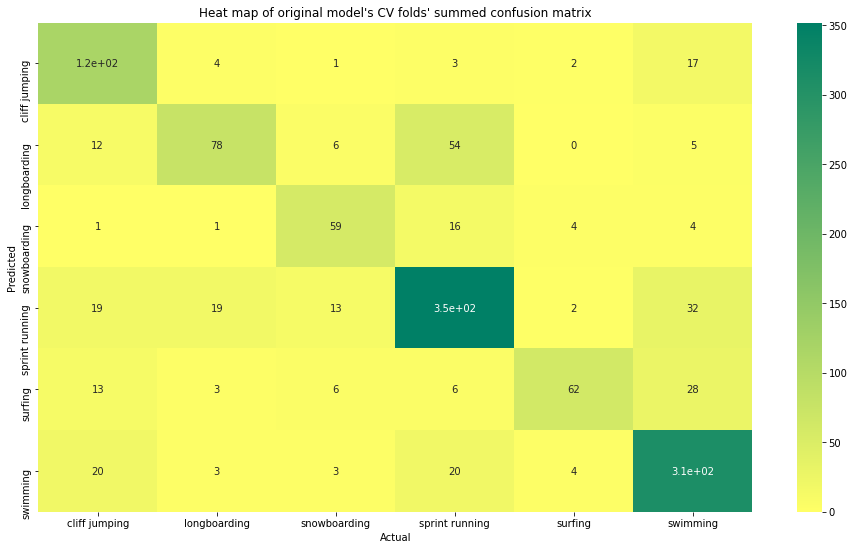

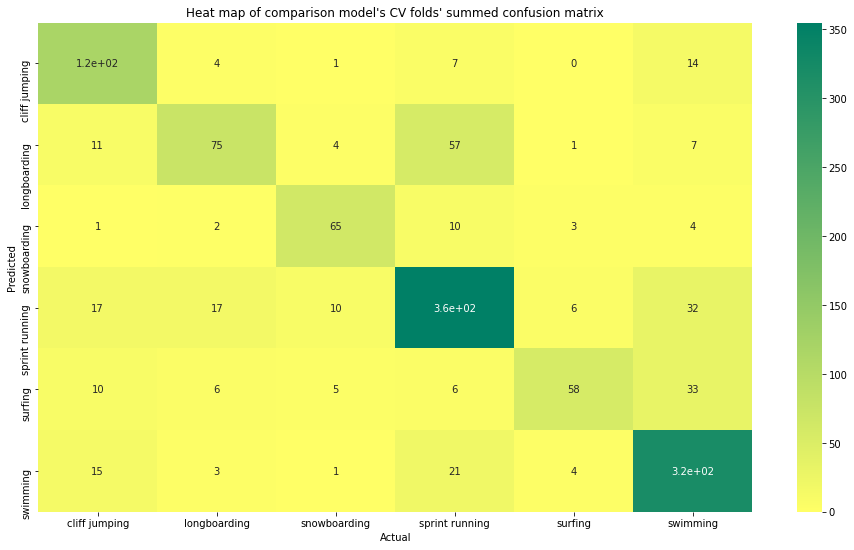

In [ ]:
# print the model score results we gathered in the previous code block
print("\n\n======== Model scores ===========")
print(tabulate(model_scores, headers=['', 'Original model', 'Comparison model']))

# generate a tabular array for pretty-printing the models' average classification report
report_data = []
comparison_report_data = []
for d_key in dict_keys:
  metric_data = [d_key]
  comparison_metric_data = [d_key]
  for m_key in metric_keys:
    metric_data.append(mean_classification_report[d_key][m_key])
    comparison_metric_data.append(comparison_mean_classification_report[d_key][m_key])
    
  report_data.append(metric_data)
  comparison_report_data.append(comparison_metric_data)

print("\n\nOriginal model's average classification report:\n")
headers = np.concatenate((np.array([]), metric_keys))
print(tabulate(report_data, headers=headers))
print("\n")

print("Comparison model's average classification report:\n")
print(tabulate(comparison_report_data, headers=headers))
print("\n\n")


# create and print a heatmap from original model's every CV fold's summed confusion matrices
plt.figure(figsize=(16, 9))
df_cfm = pd.DataFrame(model_cf_matrices_sum, index=label_binarizer.classes_, columns=label_binarizer.classes_)
ax = sns.heatmap(df_cfm, annot=True, cmap="summer_r", )
ax.set(title="Heat map of original model's CV folds' summed confusion matrix",
       xlabel="Actual",
       ylabel="Predicted")

# create and print a heatmap from comaprison model's every CV fold's summed confusion matrices
plt.figure(figsize=(16, 9))
comparison_df_cfm = pd.DataFrame(comparison_model_cf_matrices_sum, index=label_binarizer.classes_, columns=label_binarizer.classes_)
ax = sns.heatmap(comparison_df_cfm, annot=True, cmap="summer_r", )
ax.set(title="Heat map of comparison model's CV folds' summed confusion matrix",
       xlabel="Actual",
       ylabel="Predicted")


At first we can see that between all the cross-validation folds average test accuracy for the original model (which dropout value was 0.1) is 0.75 and for the comparison model (dropout value was 0.4) is 0.76, and test loss values respectively are 0.73 and 0.71. Not a big difference between the models, but 
the loss seems to be quite high and the accuracy by itself does not tell much since we have an imbalanced dataset. But let's look the classification report which has a class-wise separation of the average metrics.

In classification report precision means how many images of each class were correctly classified. So for example best precision in both models belongs to class "surfing" with 86.2 % and 83.6 % accuracies and class "cliff jumping" had the worst precision in both models with 65.9 %  and 69.8 % accuracies.

Recall means how many images from a class were found over the total number of images in that class. Class "swimming" had the best recall in both models with 86.2 % and 87.9 % accuracies and "longboarding" had the worst recalls with 50.3 % and 48.1 % accuracies.

Precision and recall are often used together to evaluate how well a machine learning model performs. [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall) says that improving precision usually decreases recall and vice versa.

F1-score tells the harmonic mean between precision and recall. By f1-score class "swiwmming" had the best performance and class "longboarding" had again the worst performance. This applies to both of the models.

Support is telling the occurencen of a given class in the dataset. The values are still averages between all cross-validation folds, but we can see the dataset proportion between classes, both "swimming" and "sprint running" has much more images in the dataset than rest of the classes have. 

By looking the classification report it can be said that at least performance of the classes "longboarding" and "surfing" are poor in both models.

With the heatmap we can get some visualization for the results. Again, all the values in the heatmap is sums of every cross-validation fold's results. Let's take the original model's (dropout value was 0.1) "longboarding" as an example to explain the heatmap, because from the metric results so far it can be said being the worst performing class, maybe we will find a good reason why that is. When taking longboarding from the heatmap's both axes, x- and y-axis, we to index $(1, 1)$ in the heatmap matrix. The value in that cell is 78, meaning during all the cross-validation folds longboarding images was classified correctly 78 times. From other columns in the same row one can see how many times an actual longboarding image was wrongly classified, for example longboarding images were classified as sprint running for 54 times. The heatmap matrix's x-axis defines actual values and y-axis predicted values. So wrongly classified images from the matrix's x-axis is called false positives and wrongly classified images from y-axis are called false negatives. Meaning for example that 4 actual longboarding images were wrongly classified to "cliff jumping". So the reason for the "longboarding" class performed quite poorly is that the labeling between those images were quite a lot mixed with "sprint running" images and because the dataset for sprint running images were much higher, the mixup did not affect to labeling the sprint running images incorrectly so much than it did for longboarding images.

There are no clear evidence that one of these compared models would clearly outperform the other. There are slim differences when labeling images belonging to individual classes, but even then the differences are quite minimal. So there are no one clear candidate for dropout parameter value to use, thus more hyperparameter tuning should be done. 

Since this is a student project and my very first machine learning application development work, the time usage for it is limited and the main goal is to practise deep learning application development, not mastering it and finding very optimal model. That is why I'm choosing to move on and use dropout parameter value 0.4 for the final model.










## 3.7 Training the final model

In [ ]:
# train the final model

# Check the output to see how long it takes to process this code block on Colab GPU
start_time = time.process_time()


dropout = 0.4


model = sequential_model_architecture(label_binarizer,
                                      lr=learning_rate,
                                      epsilon=epsilon,
                                      input_shape=img_shape,
                                      dropout=dropout)

train_generator = augment_images(train_dir,
                                 label_binarizer,
                                 img_target_size=img_target_size,
                                 batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(batch_size=batch_size,
                                                      directory=test_dir,
                                                      target_size=img_target_size,
                                                      color_mode='rgb',
                                                      class_mode='categorical',
                                                      shuffle=False)


history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data = test_generator)


test_loss, test_acc = model.evaluate(test_generator)

generator_steps = math.ceil(test_generator.n / (1.0 * batch_size))
y_pred = model.predict(test_generator, steps = generator_steps)
predicted_class_indices = np.argmax(y_pred, axis=1)
cfm = confusion_matrix(test_generator.classes, predicted_class_indices)
true_predictions = np.sum(np.diagonal(cfm))

report = classification_report(test_generator.classes,
                               predicted_class_indices,
                               target_names=label_binarizer.classes_)


model_scores = []
model_scores.append(['Accuracy', f'{test_acc:.2f}'])
model_scores.append(['Loss', f'{test_loss:.2f}'])
model_scores.append(['True predictions', true_predictions])


# compute and print elapsed time in hours, minutes and seconds
elapsed_time = time.process_time() - start_time
sec_value = elapsed_time % (24 * 3600)
hour_value = sec_value // 3600
sec_value %= 3600
min_value = sec_value // 60
sec_value %= 60

print("Wall time on Colab GPU was", hour_value, "h", min_value, "min", sec_value, "sec")


tf.keras.backend.clear_session()


Found 1303 images belonging to 6 classes.
Found 323 images belonging to 6 classes.
Epoch 1/100
41/41 [==============================] - 293s 7s/step - loss: 1.4501 - accuracy: 0.4766 - val_loss: 1.2782 - val_accuracy: 0.5263
Epoch 2/100
41/41 [==============================] - 13s 310ms/step - loss: 1.2660 - accuracy: 0.5157 - val_loss: 1.2284 - val_accuracy: 0.4954
Epoch 3/100
41/41 [==============================] - 13s 310ms/step - loss: 1.1841 - accuracy: 0.5487 - val_loss: 1.1393 - val_accuracy: 0.5263
Epoch 4/100
41/41 [==============================] - 13s 313ms/step - loss: 1.1398 - accuracy: 0.5564 - val_loss: 1.1065 - val_accuracy: 0.5573
Epoch 5/100
41/41 [==============================] - 13s 311ms/step - loss: 1.0932 - accuracy: 0.5756 - val_loss: 1.0588 - val_accuracy: 0.6099
Epoch 6/100
41/41 [==============================] - 13s 311ms/step - loss: 1.0621 - accuracy: 0.5963 - val_loss: 1.0671 - val_accuracy: 0.5728
Epoch 7/100
41/41 [==============================] - 13

#4. Results

This chapter presents the results of the experiments and how the final model is used to process an actual video.


## 4.1 Results of the final model

Below we can see the estimated performance of the final model on new data regarding test accuracy, test loss, classification report scores and a heatmap visualization from the model's confusion matrix.



======== Model scores ===========
----------------  ------
Accuracy            0.77
Loss                0.66
True predictions  250
----------------  ------

Classification report

                precision    recall  f1-score   support

 cliff jumping       0.65      0.83      0.73        36
  longboarding       0.71      0.53      0.61        38
  snowboarding       0.75      0.86      0.80        21
sprint running       0.90      0.80      0.84       109
       surfing       0.70      0.55      0.62        29
      swimming       0.75      0.88      0.81        90

      accuracy                           0.77       323
     macro avg       0.74      0.74      0.73       323
  weighted avg       0.78      0.77      0.77       323





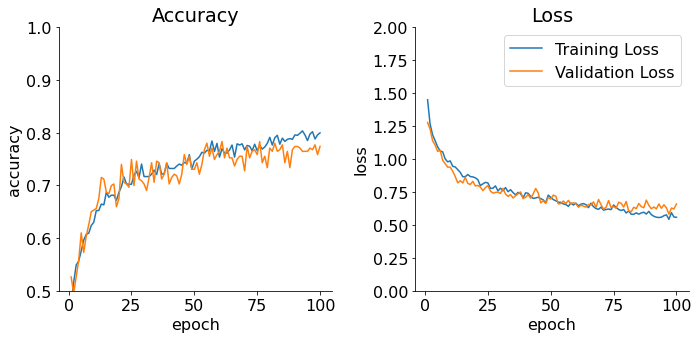

[Text(118.0, 0.5, 'Predicted'),
 Text(0.5, 55.0, 'Actual'),
 Text(0.5, 1.0, 'Confusion matrix heatmap of the model')]

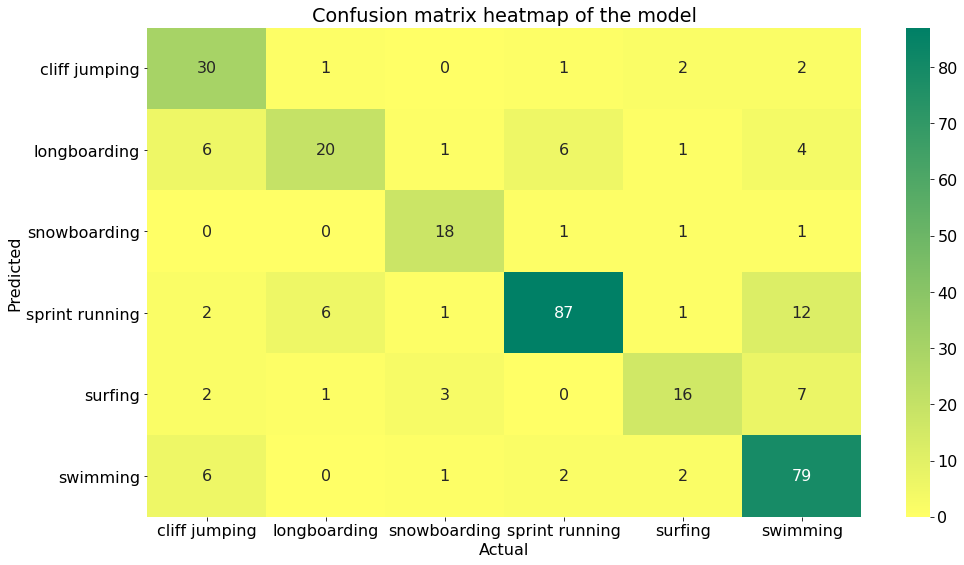

In [ ]:
print("\n\n======== Model scores ===========")
print(tabulate(model_scores))
print("\nClassification report\n")
print(report)

print("\n")
plot_history(history)

print("\n\n")

plt.figure(figsize=(16, 9))
df_cfm = pd.DataFrame(cfm, index=label_binarizer.classes_, columns=label_binarizer.classes_)
ax = sns.heatmap(df_cfm, annot=True, cmap="summer_r", )
ax.set(title="Confusion matrix heatmap of the model",
       xlabel="Actual",
       ylabel="Predicted")

The test set contained 323 images and the model predicted 250 of them correctly, so the accuracy is 77.4 %. When looking the f1-score, the worst performing classes are again "longboarding" and "surfing", as they were in the cross-validation phase as well. But the best performing class is this time "sprint running" when in the cross-validation phase it was "swimming". 

From the Accuracy and Loss graphs it looks like the model starts to overfit already after 100 epochs. This could be verified by using more epochs and it could be explained by having such a small dataset.

From the heatmap it can be seen that the worst mislabeling is when 12 of the swimming images has incorrectly been labeled as sprint running. That does not sound too much, but the dataset size is very small to begin with, so relatively speaking it is quite a lot.


## 4.2 Practical test

Now the final model has been trained so we can use it to process an actual video file. The code below is heavily based on the code on [Video classification with Keras and Deep Learning](https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/) (Rosebrock, Adrian, 15 Jul 2019).

Our input video file is located in subdirectory video, relative to the base directory defined in variable *base_dir*. Filename for the input video file is "input.mp4". The output video file "output.mp4" will be created into the same subdirectory.

In [ ]:
# provides functionality for image and video processing
import cv2

# list-like container with fast appends and pops on either end
from collections import deque 

# define input and output video file paths
base_video_dir = os.path.join(base_dir, 'video')
input_video_file = os.path.join(base_video_dir, 'input.mp4')
output_video_file = os.path.join(base_video_dir, 'output.mp4')

# initialize the image mean for mean subtraction along with the
# predictions queue
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=32)

# initialize the video stream, pointer to output video file, and frame dimensions
vs = cv2.VideoCapture(input_video_file)
writer = None
(W, H) = (None, None)

print("[INFO] Starting to process the video...")

# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
	# if the frame was not grabbed, then we have reached the end of the stream
	if not grabbed:
		break
	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

  # clone the output frame, then convert it from BGR to RGB ordering, resize 
	# the frame to a fixed 224x224, and then perform mean subtraction
	output = frame.copy()
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = cv2.resize(frame, img_target_size).astype("float32")
	frame -= mean

  # make predictions on the frame and then update the predictions queue
	preds = model.predict(np.expand_dims(frame, axis=0))[0]
	Q.append(preds)
	# perform prediction averaging over the current history of
	# previous predictions
	results = np.array(Q).mean(axis=0)
	i = np.argmax(results)
	label = label_binarizer.classes_[i]

  # draw the activity on the output frame
	cv2.putText(output, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (116, 255, 0), 3)
	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(output_video_file, fourcc, 30, (W, H), True)
	# write the output frame to disk
	writer.write(output)

print("[INFO] ...done processing the video.")

# release the file pointers
print("[INFO] Cleaning up...")
writer.release()
vs.release()
print("[INFO] ...done.")

[INFO] Starting to process the video...
[INFO] ...done processing the video.
[INFO] Cleaning up...
[INFO] ...done.


Here we have [the video clip](https://youtu.be/a5HYt9X7N4E) used as an input video for our developed deep learning application.

In [ ]:
# provides functionality to display videos from youtube
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/a5HYt9X7N4E?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


And [the result](https://youtu.be/LZPt4TU6xpg) after running it through our deep learning application.

In [ ]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/LZPt4TU6xpg?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


# 5. Conclusions

The project work was a real learning experience since it was my very first work to develop a functioning machine learning application. 

The model's performance could be better, it is not an a satisfactory level. The most straight-forward approach to improve its performance would be to use more training data and also more balanced training data. Here the image amounts between classes varied quite a lot and for some classes there were under 100 images for training which is very small amount for training a deep learning model. I didn't have much time to fiddle around with the hyperparameters and tune them perfectly, and I'm sure some improvement could be found by using more time to get more optimal hyperparameter tuning, but using better training data would still have more improvement. Especially since I have used classes which can be very similar to others, for example longboarding, snowboarding and surfing, or swimming and cliff jumping.

I wanted to learn by doing some trial and error so I searched what research from the topic was done only after I had completed my application. Zuxuan et. al ([Deep Learning for Video Classification and Captioning](https://arxiv.org/pdf/1609.06782.pdf), Feb, 2018) says that [AlexNet](https://en.wikipedia.org/wiki/AlexNet) was successfully applied to large-scale image classification in  [ImageNet Challenge](http://www.image-net.org/challenges/LSVRC/). Two components were introduced in AlexNet compared to earlier, not so well performing models, regarding large scale image classification. The components were

1.   Using Rectified Liner Units (ReLu) as activation functions instead of Hyperbolic tangent (Tanh) functions. That made the training process several times faster.
2.   Introducing dropout, which proved to be very effective in alleviating overfitting.

Although I knew there would probably be datasets available to use in this application's context, I still wanted to learn the development process from the scratch and acquire the training images by myself. Using some already collected and available dataset would surely give a better starting point than the dataset I collected and used. For example, Karpathy, et. al ([Large-scale Video Classification with Convolutional Neural Networks](https://cs.stanford.edu/people/karpathy/deepvideo/index.html), 2014) has made a new Sports-1M dataset collection consisting of 1 million YouTube videos belonging to 487 different classes of sports, and they have made it available to the research community to use the collection.







<video controls src="./data/video/input.mp4">input video</video>
